In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

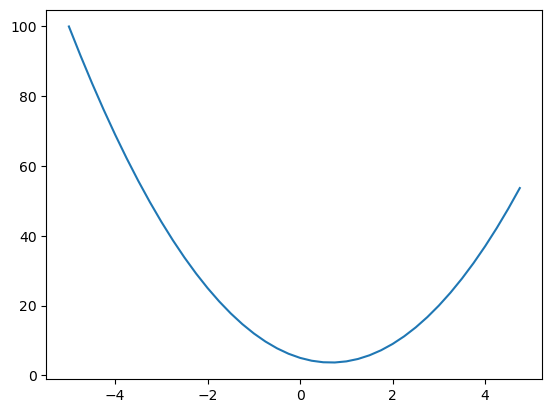

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs , ys)
plt.show()

In [5]:
h = 0.000000001
x = 3.0
(f(x+h) - f(x))/h

14.000001158365194

In [6]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a+=h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [27]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = '') -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self) -> str:
        return f"Value(data = {self.data}, label = {self.label})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = out.grad
            other.grad = out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b 
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot  


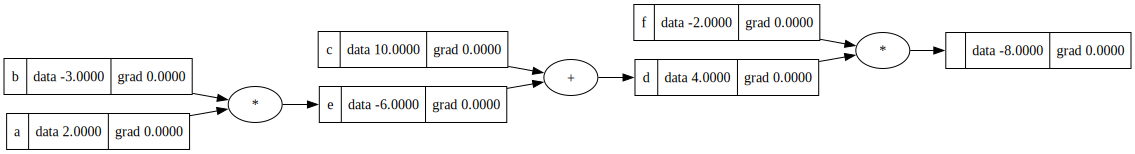

In [10]:
draw_dot(L)

In [11]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

a.data+=0.01 * a.grad
b.data+=0.01 * b.grad
c.data+=0.01 * c.grad
f.data+=0.01 * f.grad

e = a * b
d = e + c
L  = d * f
print(L.data)

-7.286496


In [12]:
def lol():
    h = 0.0001
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b 
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f
    L.label = 'l'
    L1 = L.data
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b 
    e.label = 'e'
    d = e + c
    d.data+=h
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f
    L.label = 'l'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()

-1.9999999999953388


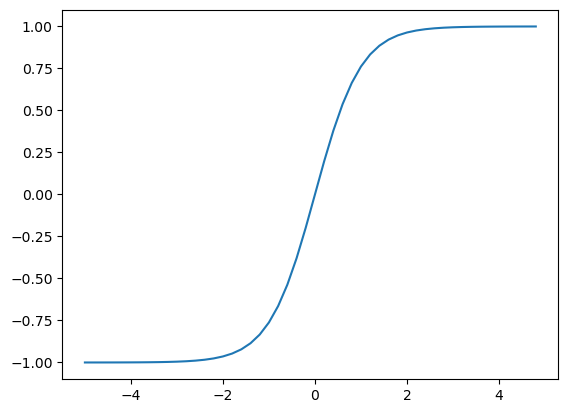

In [13]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.show()

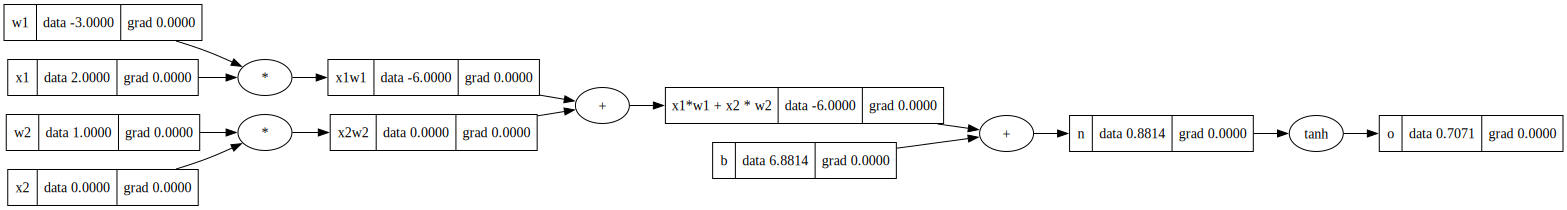

In [31]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2 * w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

draw_dot(o)

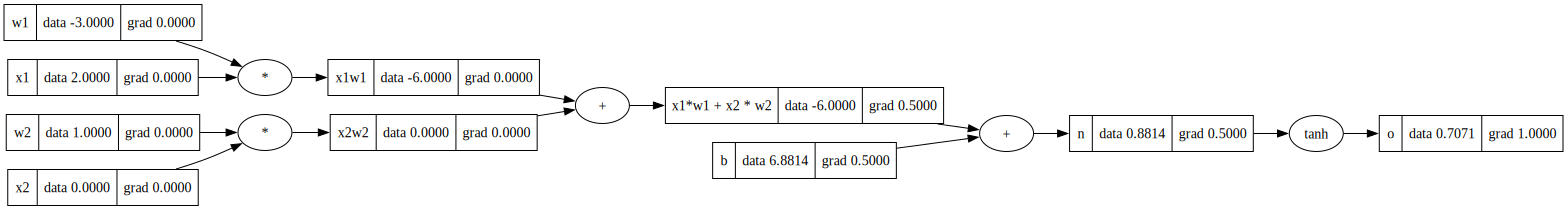

In [38]:
draw_dot(o)

In [34]:
# n.grad = 0.5
# o.grad = 1.0
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad
o.grad = 1.0
o._backward()
n._backward()

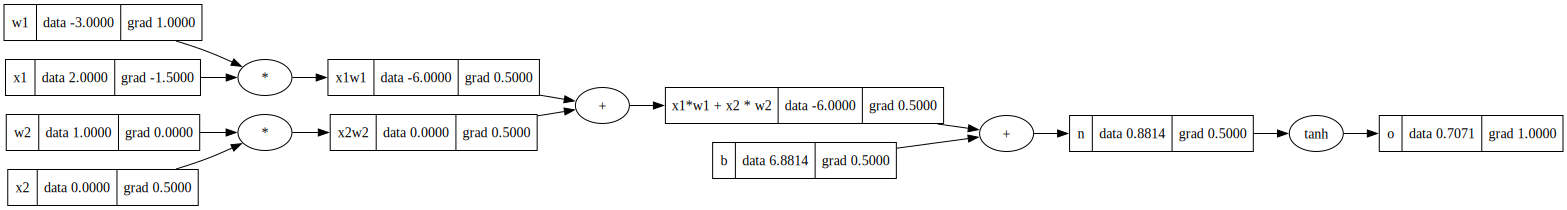

In [47]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
for node in reversed(topo):
    node._backward()

draw_dot(o)